# **Transformers Pre-Training: Masked Language Modeling**
---

- Implementing Encoder-Only Transformer model
- Preparing the dataset from scratch
- Training BERT-like tokenizer from scratch
- Training from scratch with MLM objective
- Trained on Wikipedia dataset from scratch

# Imports
---

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm
import random
from sklearn.model_selection import train_test_split
from tokenizers import Tokenizer
from tokenizers.models import WordPiece
from tokenizers import normalizers
from tokenizers.normalizers import NFD, Lowercase, StripAccents
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import WordPieceTrainer
from tokenizers import decoders
from sklearn.metrics import accuracy_score
from transformers import AutoTokenizer
from IPython.display import Image 

In [2]:
torch.cuda.is_available()

True

# Training Tokenizer
---

In [3]:
with open('/home/data/sample_wikisent2.txt','r') as f:
    lines = f.read().split('\n')
    lines = random.choices(lines,k=700_00)
    lines = [ln for ln in lines if len(ln)>1]
    train_lines, val_lines = train_test_split(lines,test_size=0.1,shuffle=True)
    val_lines, test_lines = train_test_split(val_lines,test_size=0.2,shuffle=True)
    
len(lines), len(train_lines), len(val_lines), len(test_lines)

(70000, 63000, 5600, 1400)

In [4]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

In [5]:
txt = 'this is a sample text! Shreyas'
a = tokenizer.tokenize(txt)
tok = tokenizer.encode(txt)
for i,t in zip(a, tok):
    print(f'{i}:{t} ',end=' ')
tokenizer.decode(tok)

this:101  is:1142  a:1110  sample:170  text:6876  !:3087  S:106  ##hr:156  ##ey:8167  ##as:2254  

2025-01-19 10:53:08.240830: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-19 10:53:08.413495: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737283988.508049      21 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737283988.533427      21 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-19 10:53:08.748328: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appro

'[CLS] this is a sample text! Shreyas [SEP]'

In [6]:
tokenizer.convert_tokens_to_ids("[UNK]"),tokenizer.convert_tokens_to_ids("[PAD]"),tokenizer.convert_tokens_to_ids("[MASK]")

(100, 0, 103)

### Tips for Pytorch data loader Custom Dataset classes

If you want to create a custom data class to be used with `torch.utils.data.DataLoader`, you need to define a class that adheres to the `torch.utils.data.Dataset` interface. Specifically, you need to implement the following methods in your custom dataset class:

---

### 1. **`__len__`**
- This method should return the number of samples in your dataset.
- It enables the `DataLoader` to know the size of the dataset and how many batches to create.

**Example:**
```python
def __len__(self):
    return len(self.data)  # Replace with the length of your dataset
```

---

### 2. **`__getitem__`**
- This method retrieves a single sample from your dataset at the specified index.
- It should return the data and label (or whatever information your dataset contains) in a format expected by your model.

**Example:**
```python
def __getitem__(self, idx):
    sample = self.data[idx]  # Replace with how you access your data
    label = self.labels[idx]  # Replace with how you access your labels
    return sample, label
```

---

### Optional: **Other Custom Methods**
Depending on your dataset's requirements, you might also define additional methods or custom logic:
1. **Preprocessing or Augmentation:**
   - Apply transformations to the data (e.g., normalization, cropping, or flipping).
   - Use `torchvision.transforms` or define your own.

**Example:**
```python
def __getitem__(self, idx):
    sample = self.data[idx]
    label = self.labels[idx]
    if self.transform:
        sample = self.transform(sample)
    return sample, label
```

2. **Initialization (`__init__`):**
   - Load the dataset, handle file paths, and set up any preprocessing steps or metadata.

**Example:**
```python
def __init__(self, data, labels, transform=None):
    self.data = data
    self.labels = labels
    self.transform = transform
```

---

### Full Example: Custom Dataset Class
Here’s a complete example:
```python
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample, label
```

---

### Integration with DataLoader
You can now use your custom dataset with `DataLoader`:
```python
from torch.utils.data import DataLoader

# Example data
data = [[1, 2], [3, 4], [5, 6], [7, 8]]
labels = [0, 1, 0, 1]

# Instantiate the dataset
dataset = CustomDataset(data, labels)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

# Iterate through the DataLoader
for batch in dataloader:
    print(batch)
```

---

### Advanced Usage
1. **Dynamic Datasets**: Override `__getitem__` to handle dynamic data loading (e.g., from disk or a database).
2. **Weighted Sampling**: Pair with `torch.utils.data.WeightedRandomSampler` to sample data non-uniformly.
3. **Custom Collate Function**: Pass a `collate_fn` to `DataLoader` for custom batching logic.

By implementing these methods, your custom dataset will be fully compatible with PyTorch's `DataLoader`.

# Preparing Dataset
---

- in Masked Language Modeling, the loss calculation is similar to that of causalLMs
- the inputs and the labels are identical in terms of position
- in the inputs:
    - 15% of the tokens are masked / replaced randomly by the `[MASK]` token
    - this 15% doesn't include the pad tokens
- in the labels:
    - the ground-truth tokens which were masked in the inputs are present in the labels
    - all other tokens are ignored (set to -100) by the default behaviour of nn.CrossEntropyLoss    

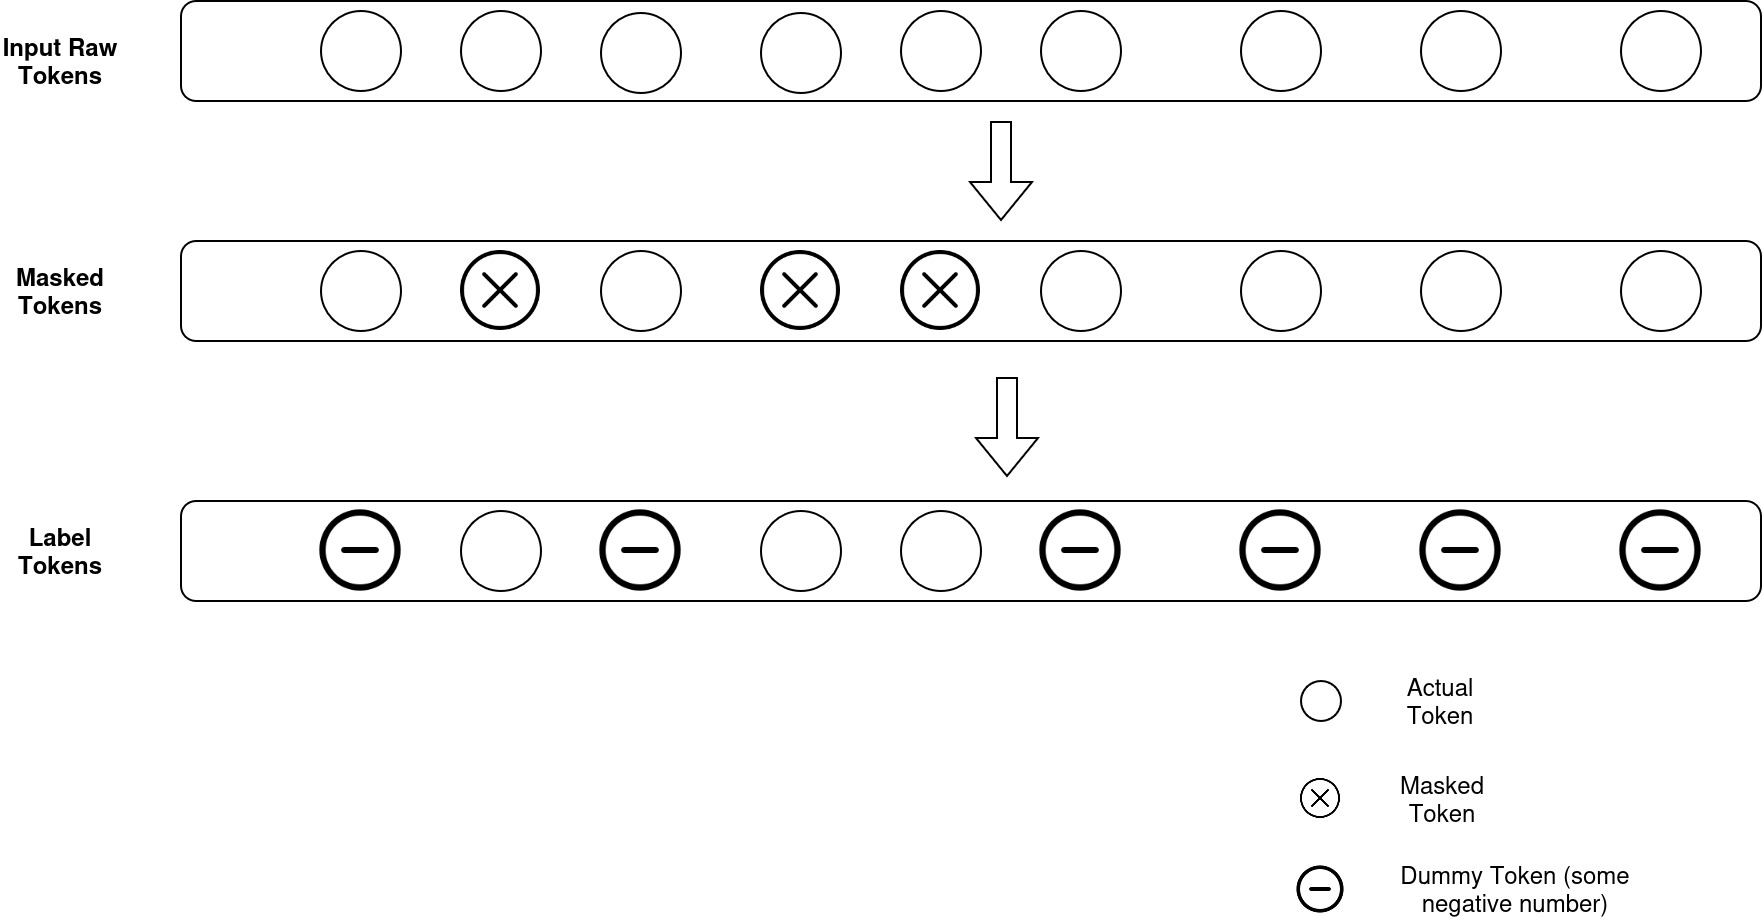

In [7]:
Image(filename='../../data/mask_language_model.jpg')

## Cross-Entropy Calculation (Detailed Step by Step)

- https://chatgpt.com/share/6783aa14-455c-800f-bda8-ae4108c4b99a
- Personal study notes in tab

In [8]:
class MLMDataset:
    def __init__(self,lines):
        self.lines = lines
    def __len__(self,):
        return len(self.lines)
    def __getitem__(self,idx):
        line = self.lines[idx]
        ids = tokenizer.encode(line, padding="max_length", max_length=128, truncation=True, )
        labels = ids.copy()
        return ids, labels
    
def collate_fn(batch):
    input_ids = [torch.tensor(i[0]) for i in batch]
    labels = [torch.tensor(i[1]) for i in batch]
    input_ids = torch.stack(input_ids)
    labels = torch.stack(labels)
    # mask 15% of text leaving [PAD]
    mlm_mask = torch.rand(input_ids.size()) < 0.15 * (input_ids!=0)
    masked_tokens = input_ids * mlm_mask
    labels[masked_tokens==0]=-100 # set all tokens except masked tokens to -100
    input_ids[masked_tokens!=0]=103 # MASK TOKEN
    return input_ids, labels

In [9]:
ds = MLMDataset(lines)
dl = torch.utils.data.DataLoader(ds,batch_size=2,shuffle=True,collate_fn=collate_fn)

## this is how a sample looks
---

In [10]:
i,l = next(iter(dl))
print(i[1])
print(l[1])

tensor([  101,  1109,  8170,   117,  1227,  6889,  1112,  2161,   160, 14788,
          103,  4671,   117,  1110,  1388,  1373,  1103,  2359, 16084,   103,
         2161,   103, 14788, 16339,   119,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0])

# Encoder-Only Transformer Model
---

- straightforward simple implementation.
- nn.LayerNorm replaced with RMSNorm which is preferred to by many.
- It looks like BERT but it is not BERT. BERT is more complicated than this.
- Only implementing the MLM part of BERT so no need of [CLS] and [SEP] tokens
- Learned positional embeddings instead of sinusoidal in BERT.
- We can have a mask for the encoder self-attention as well by masking out the pad tokens so attention layers ignore the extra stuff.
- For inference currently only supports batch size of 1.
- After the encoder outputs pass through the `dim->vocab` Linear layer, the logits at the position where the token was masked are softmaxed and then with argmax the token that's supposed to be there is predicted.

```
out: 1 x 128 x 256
if the input sequence for inference was masked at position 4, we extract 1 x 256 at index 4:
preds: out[:,4,:]
softmax -> argmax
preds: predicted token
```

RMSNorm (Root Mean Square Normalization) is a normalization technique used primarily in neural networks, particularly in transformer architectures, as an alternative to LayerNorm. It was introduced to address some of the inefficiencies of LayerNorm and has been shown to work well in practice, particularly in large-scale models.

### How RMSNorm Works
RMSNorm normalizes inputs using their root mean square (RMS) rather than their mean and variance. It avoids computing the mean, focusing instead on the magnitude of the input vector, which can lead to faster computations and simpler implementation. 

### Formula
For a given input vector $$x \in \mathbb{R}^d :$$
1. Compute the RMS of the vector:
   $$
   \text{RMS}(x) = \sqrt{\frac{1}{d} \sum_{i=1}^d x_i^2}
   $$

2. Normalize the input:
   $$
   y = \frac{x}{\text{RMS}(x)} \odot \gamma
   $$
   Here:
   - $\gamma$ is a learned scaling parameter (similar to LayerNorm),
   - $\odot$ denotes element-wise multiplication.

### Key Differences from LayerNorm
- **Efficiency**: RMSNorm avoids computing the mean, making it computationally simpler and potentially faster.
- **No Subtraction Step**: LayerNorm subtracts the mean from the input before normalization, while RMSNorm directly normalizes using RMS.
- **Scale Invariance**: RMSNorm is inherently scale-invariant because it doesn't depend on the mean of the input, which can help in some scenarios.

### Advantages
- **Efficiency**: Computationally less intensive than LayerNorm.
- **Stability**: Works well in scenarios where LayerNorm might struggle with small batch sizes or specific scaling issues.
- **Flexibility**: Often used in transformer-based models where speed and simplicity are crucial.

### Disadvantages
- **No Mean Adjustment**: By not centering the input (subtracting the mean), RMSNorm may not always capture certain input characteristics that LayerNorm does.

### Applications
RMSNorm has been used in transformer models and large language models as a replacement for LayerNorm. It’s particularly popular in scenarios where:
- Large-scale models need efficient computation,
- Normalization must maintain scale invariance.

If you'd like, I can provide PyTorch code to implement RMSNorm! Let me know.

In [11]:
# https://github.com/bzhangGo/rmsnorm/blob/master/rmsnorm_torch.py
class RMSNorm(nn.Module):
    def __init__(self, d, p=-1., eps=1e-8, bias=False):
        """
            Root Mean Square Layer Normalization
        :param d: model size
        :param p: partial RMSNorm, valid value [0, 1], default -1.0 (disabled)
        :param eps:  epsilon value, default 1e-8
        :param bias: whether use bias term for RMSNorm, disabled by
            default because RMSNorm doesn't enforce re-centering invariance.
        """
        super(RMSNorm, self).__init__()

        self.eps = eps
        self.d = d
        self.p = p
        self.bias = bias

        self.scale = nn.Parameter(torch.ones(d))
        self.register_parameter("scale", self.scale)

        if self.bias:
            self.offset = nn.Parameter(torch.zeros(d))
            self.register_parameter("offset", self.offset)

    def forward(self, x):
        if self.p < 0. or self.p > 1.:
            norm_x = x.norm(2, dim=-1, keepdim=True)
            d_x = self.d
        else:
            partial_size = int(self.d * self.p)
            partial_x, _ = torch.split(x, [partial_size, self.d - partial_size], dim=-1)

            norm_x = partial_x.norm(2, dim=-1, keepdim=True)
            d_x = partial_size

        rms_x = norm_x * d_x ** (-1. / 2)
        x_normed = x / (rms_x + self.eps)

        if self.bias:
            return self.scale * x_normed + self.offset

        return self.scale * x_normed

In [12]:
class MultiheadAttention(nn.Module):
    def __init__(self, dim, n_heads, dropout=0.):
        super().__init__()
        self.dim = dim
        self.n_heads = n_heads
        assert dim % n_heads == 0, 'dim should be div by n_heads'
        self.head_dim = self.dim // self.n_heads
        self.in_proj = nn.Linear(dim,dim*3,bias=False)
        self.attn_dropout = nn.Dropout(dropout)
        self.scale = self.head_dim ** -0.5
        self.out_proj = nn.Linear(dim,dim)
        
    def forward(self,x,mask=None):
        b,t,c = x.shape
        q,k,v = self.in_proj(x).chunk(3,dim=-1)
        q = q.view(b,t,self.n_heads,self.head_dim).permute(0,2,1,3)
        k = k.view(b,t,self.n_heads,self.head_dim).permute(0,2,1,3)
        v = v.view(b,t,self.n_heads,self.head_dim).permute(0,2,1,3)
        
        qkT = torch.matmul(q,k.transpose(-1,-2)) * self.scale
        qkT = self.attn_dropout(qkT)
        
        if mask is not None:
            mask = mask.to(dtype=qkT.dtype,device=qkT.device)
            qkT = qkT.masked_fill(mask==0,float('-inf'))
            
              
        qkT = F.softmax(qkT,dim=-1)
        attn = torch.matmul(qkT,v)
        attn = attn.permute(0,2,1,3).contiguous().view(b,t,c)
        out = self.out_proj(attn)
        
        return out

In [13]:
class FeedForward(nn.Module):
    def __init__(self,dim,dropout=0.):
        super().__init__()
        self.feed_forward = nn.Sequential(
            nn.Linear(dim,dim*4),
            nn.Dropout(dropout),
            nn.GELU(),
            nn.Linear(dim*4,dim)
        )
        
    def forward(self, x):
        return self.feed_forward(x)

In [14]:
class EncoderBlock(nn.Module):
    def __init__(self, dim, n_heads, attn_dropout=0., mlp_dropout=0.):
        super().__init__()
        self.attn = MultiheadAttention(dim,n_heads,attn_dropout)
        self.ffd = FeedForward(dim,mlp_dropout)
        self.ln_1 = RMSNorm(dim)
        self.ln_2 = RMSNorm(dim)
        
    def forward(self,x,mask=None):
        x = self.ln_1(x)
        x = x + self.attn(x,mask)
        x = self.ln_2(x)
        x = x + self.ffd(x)
        return x

In [15]:
class Embedding(nn.Module):
    def __init__(self,vocab_size,max_len,dim):
        super().__init__()
        self.max_len = max_len
        self.class_embedding = nn.Embedding(vocab_size,dim)
        self.pos_embedding = nn.Embedding(max_len,dim)
    def forward(self,x):
        x = self.class_embedding(x)
        pos = torch.arange(0,x.size(1),device=x.device)
        x = x + self.pos_embedding(pos)
        return x

In [16]:
class MLMBERT(nn.Module):
    def __init__(self, config):
        
        super().__init__()
        
        self.embedding = Embedding(config['vocab_size'],config['max_len'],config['dim'])
        
        self.depth = config['depth']
        self.encoders = nn.ModuleList([
            EncoderBlock(
                dim=config['dim'],
                n_heads=config['n_heads'],
                attn_dropout=config['attn_dropout'],
                mlp_dropout=config['mlp_dropout']
            ) for _ in range(self.depth)
        ])
        
        self.ln_f = RMSNorm(config['dim'])
        
        self.mlm_head = nn.Linear(config['dim'],config['vocab_size'],bias=False)
        
        self.embedding.class_embedding.weight = self.mlm_head.weight # weight tying
        
        self.pad_token_id = config['pad_token_id']
        self.mask_token_id = config['mask_token_id']
        
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        
    def create_src_mask(self,src):
        return (src != self.pad_token_id).unsqueeze(1).unsqueeze(2) # N, 1, 1, src_len
    
    def forward(self,input_ids,labels=None):
        
        src_mask = self.create_src_mask(input_ids)
        
        enc_out = self.embedding(input_ids)

        for layer in self.encoders:
            enc_out = layer(enc_out,mask=src_mask)
        
        enc_out = self.ln_f(enc_out)
        
        logits = self.mlm_head(enc_out)
        
        if labels is not None:
            #loss = F.cross_entropy(logits.view(-1,logits.size(-1)),labels.view(-1))
            # Masked token positions
            mask_positions = (input_ids == self.mask_token_id)

            # Select logits and labels only for masked positions
            masked_logits = logits[mask_positions]
            masked_labels = labels[mask_positions]

            # Compute loss only on masked positions
            loss = F.cross_entropy(masked_logits, masked_labels)
            return {'loss': loss, 'logits': logits}
        else:
            # assuming inference input_ids only have 1 [MASK] token
            mask_idx = (input_ids==self.mask_token_id).flatten().nonzero().item()
            mask_preds = F.softmax(logits[:,mask_idx,:],dim=-1).argmax(dim=-1)
            return {'mask_predictions':mask_preds}

# Training Preparation
---

In [17]:
tokenizer.vocab_size

28996

In [18]:
config = {
    'dim': 256,
    'n_heads': 4,
    'attn_dropout': 0.1,
    'mlp_dropout': 0.1,
    'depth': 8,
    'vocab_size': 28996,
    'max_len': 128,
    'pad_token_id': 0,
    'mask_token_id': 103
}

In [21]:
model = MLMBERT(config).to('cuda')
print('trainable:',sum([p.numel() for p in model.parameters() if p.requires_grad]))

trainable: 13763840


In [22]:
train_ds = MLMDataset(train_lines)
val_ds = MLMDataset(val_lines)

In [23]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=60, shuffle=True, collate_fn=collate_fn)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=60, shuffle=False, collate_fn=collate_fn)

## Calculating accuracy by masking only 1 token
---

- Not a great metric but I wanted something basic to begin with.

In [24]:
# TEST : SINGLE TOKEN MASKING

test_actuals = []
test_batches = []
for ln in tqdm(test_lines):
    tokenized = tokenizer(ln, padding="max_length", max_length=128, truncation=True, add_special_tokens=True, return_special_tokens_mask=True)
    fi = len(tokenized.input_ids)
    if 1 in tokenized.special_tokens_mask:
        fi = torch.tensor(tokenized.special_tokens_mask[1:]).nonzero()[0].item() # ignore [PAD]
    m = torch.randint(0,fi,(1,)).item() # select random token to mask
    input_ids = torch.tensor(tokenized.input_ids)
    test_actuals.append(input_ids[m].item())
    input_ids[m]=103 # replace with [MASK]
    test_batches.append(input_ids)

  0%|          | 0/1400 [00:00<?, ?it/s]

# Training
---

In [25]:
epochs = 20
train_losses = []
valid_losses = []
test_accuracies = []
best_val_loss = 1e9

In [26]:
optim = torch.optim.Adam(model.parameters(),lr=6e-4 / 25) #lr = 6e-4 / 25.
sched = torch.optim.lr_scheduler.OneCycleLR(optim,max_lr=6e-4,steps_per_epoch=len(train_dl),epochs=epochs)

In [27]:
for ep in tqdm(range(epochs)):
    model.train()
    trl = 0.
    tprog = tqdm(enumerate(train_dl),total=len(train_dl))
    for i, (input_ids, labels) in tprog:
        input_ids = input_ids.to('cuda')
        labels = labels.to('cuda')
        loss = model(input_ids,labels)['loss']
        loss.backward()
        optim.step()
        optim.zero_grad()
        sched.step()
        trl += loss.item()
        tprog.set_description(f'train step loss: {loss.item():.4f}')
    train_losses.append(trl/len(train_dl))
        
    model.eval()
    with torch.no_grad():
        vrl = 0.
        vprog = tqdm(enumerate(val_dl),total=len(val_dl))
        for i, (input_ids, labels) in vprog:

            input_ids = input_ids.to('cuda')
            labels = labels.to('cuda')
            loss = model(input_ids,labels)['loss']
            vrl += loss.item()
            vprog.set_description(f'valid step loss: {loss.item():.4f}')
        vloss = vrl/len(val_dl)
        valid_losses.append(vloss)
        print(f'epoch {ep} | train_loss: {train_losses[-1]:.4f} valid_loss: {valid_losses[-1]:.4f}')
        
        if vloss < best_val_loss:
            best_val_loss = vloss
            print('PREDICTING!')
            test_predictions = []
            for input_ids in tqdm(test_batches):
                input_ids = input_ids.unsqueeze(0)
                input_ids = input_ids.to('cuda')
                mask_preds = model(input_ids)['mask_predictions']
                test_predictions.extend(list(mask_preds.detach().cpu().flatten().numpy()))
            
            tacc = accuracy_score(test_actuals, test_predictions)
            test_accuracies.append(tacc)
            print(f'SINGLE MASK TOKEN PREDICTION ACCURACY: {tacc:.4f}')
            print('saving best model...')
            sd = model.state_dict()
            torch.save(sd,'./mlm-baby-bert/model.pt')

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1050 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

epoch 0 | train_loss: 7.7832 valid_loss: 6.7747
PREDICTING!


  0%|          | 0/1400 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.1057
saving best model...


  0%|          | 0/1050 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

epoch 1 | train_loss: 6.7139 valid_loss: 6.6130
PREDICTING!


  0%|          | 0/1400 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.1221
saving best model...


  0%|          | 0/1050 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

epoch 2 | train_loss: 6.3127 valid_loss: 5.7304
PREDICTING!


  0%|          | 0/1400 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.2143
saving best model...


  0%|          | 0/1050 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

epoch 3 | train_loss: 5.3918 valid_loss: 5.1114
PREDICTING!


  0%|          | 0/1400 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.2614
saving best model...


  0%|          | 0/1050 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

epoch 4 | train_loss: 4.9601 valid_loss: 4.8737
PREDICTING!


  0%|          | 0/1400 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.2886
saving best model...


  0%|          | 0/1050 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

epoch 5 | train_loss: 4.6988 valid_loss: 4.6193
PREDICTING!


  0%|          | 0/1400 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.3014
saving best model...


  0%|          | 0/1050 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

epoch 6 | train_loss: 4.4692 valid_loss: 4.4156
PREDICTING!


  0%|          | 0/1400 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.3164
saving best model...


  0%|          | 0/1050 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

epoch 7 | train_loss: 4.2728 valid_loss: 4.3112
PREDICTING!


  0%|          | 0/1400 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.3364
saving best model...


  0%|          | 0/1050 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

epoch 8 | train_loss: 4.0849 valid_loss: 4.1952
PREDICTING!


  0%|          | 0/1400 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.3550
saving best model...


  0%|          | 0/1050 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

epoch 9 | train_loss: 3.9275 valid_loss: 4.0677
PREDICTING!


  0%|          | 0/1400 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.3571
saving best model...


  0%|          | 0/1050 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

epoch 10 | train_loss: 3.7607 valid_loss: 3.9700
PREDICTING!


  0%|          | 0/1400 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.3771
saving best model...


  0%|          | 0/1050 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

epoch 11 | train_loss: 3.6126 valid_loss: 3.8677
PREDICTING!


  0%|          | 0/1400 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.3836
saving best model...


  0%|          | 0/1050 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

epoch 12 | train_loss: 3.4695 valid_loss: 3.8237
PREDICTING!


  0%|          | 0/1400 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.4029
saving best model...


  0%|          | 0/1050 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

epoch 13 | train_loss: 3.3090 valid_loss: 3.6919
PREDICTING!


  0%|          | 0/1400 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.4086
saving best model...


  0%|          | 0/1050 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

epoch 14 | train_loss: 3.1849 valid_loss: 3.6598
PREDICTING!


  0%|          | 0/1400 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.4136
saving best model...


  0%|          | 0/1050 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

epoch 15 | train_loss: 3.0756 valid_loss: 3.6192
PREDICTING!


  0%|          | 0/1400 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.4343
saving best model...


  0%|          | 0/1050 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

epoch 16 | train_loss: 2.9801 valid_loss: 3.4864
PREDICTING!


  0%|          | 0/1400 [00:00<?, ?it/s]

SINGLE MASK TOKEN PREDICTION ACCURACY: 0.4286
saving best model...


  0%|          | 0/1050 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

epoch 17 | train_loss: 2.9160 valid_loss: 3.5500


  0%|          | 0/1050 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

epoch 18 | train_loss: 2.8671 valid_loss: 3.5366


  0%|          | 0/1050 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

epoch 19 | train_loss: 2.8404 valid_loss: 3.4894


In [26]:
torch.cuda.empty_cache()

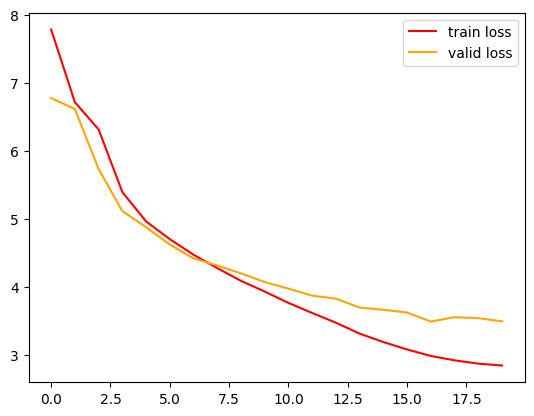

In [28]:
plt.plot(train_losses,color='red',label='train loss')
plt.plot(valid_losses,color='orange',label='valid loss')
plt.legend()
plt.show()

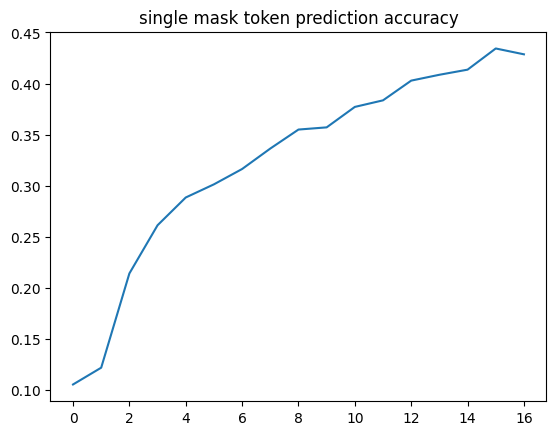

In [29]:
plt.plot(test_accuracies)
plt.title('single mask token prediction accuracy')
plt.show()

In [29]:
# best model
sd = torch.load('./mlm-baby-bert/model.pt')
model.load_state_dict(sd)

<All keys matched successfully>

In [30]:
def predict_mask(sentence):
    
    x = tokenizer(sentence, padding="max_length", max_length=128, truncation=True, add_special_tokens=True, return_special_tokens_mask=True)
    
    # picking an index to mask, range: [0,len-1]
    fi = len(x.input_ids)
    # if the sample contains pad tokens, we can't mask them, so limiting the end index to ignore padding
    if 1 in x.special_tokens_mask:
        fi = torch.tensor(x.special_tokens_mask[1:]).nonzero()[0].item() # ignore [PAD]
    # random index to mask
    idx = torch.randint(0,fi,(1,)).item()
    
    input_ids = x.input_ids.copy()
    masked_token = tokenizer.decode([input_ids[idx]])
    
    # masking
    input_ids[idx] = 103 # idx -> [MASK]
    masked_sentence = input_ids.copy()
    
    # preparing input
    input_ids = torch.tensor(input_ids,dtype=torch.long).unsqueeze(0).to('cuda')
    
    # extracting the predicted token
    out = model(input_ids)
    predicted = x.input_ids.copy()
    predicted[idx] = out['mask_predictions'].item()
    predicted_token = tokenizer.decode([out['mask_predictions'].item()])
    
    print(f'masked: {masked_token} predicted: {predicted_token}')
    masked_sentence = tokenizer.decode(masked_sentence,skip_special_tokens=False)
    masked_sentence = masked_sentence.replace('[PAD]','')
    print('ACTUAL:',sentence)
    print('MASKED:',masked_sentence)
    print(' MODEL:',tokenizer.decode(predicted))
    
    return int(masked_token == predicted_token)

In [31]:
correct = 0
for sentence in random.choices(train_lines+test_lines,k=100):
    correct += predict_mask(sentence)
    print('\n\n')
print(f'CORRECT:{correct}/{100}')

masked: prior predicted: City
ACTUAL: During his nine years at The Atlantic prior to becoming editor, Goldberg became known for his coverage of foreign affairs.
MASKED: [CLS] During his nine years at The Atlantic [MASK] to becoming editor, Goldberg became known for his coverage of foreign affairs. [SEP]                                                                                                        
 MODEL: [CLS] During his nine years at The Atlantic City to becoming editor, Goldberg became known for his coverage of foreign affairs. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

masked: ##2 predicted: ##A
ACTUAL: NACHT, LRR and PYD domains-containing protein 2 is a protein that in humans is encoded by the NLRP2 gene.
MASKED: [CLS] NACHT, LRR and PYD domains - containing protein 2 is a protein that in humans is encoded by the NLRP [MASK] gene. [SEP]                                                                                               
 MODEL: [CLS] NACHT, LRR and PYD domains - containing protein 2 is a protein that in humans is encoded by the NLRPA gene. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

masked: ##cha predicted: ##lla
ACTUAL: Tytocha is a genus of Moth in the family Lasiocampidae.
MASKED: [CLS] Tyto [MASK] is a genus of Moth in the family Lasiocampidae. [SEP]                                                                                                            
 MODEL: [CLS] Tytolla is a genus of Moth in the family Lasiocampidae. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

masked: form predicted: of
ACTUAL: The cover is an image form the 1963 film, Black Sabbath.
MASKED: [CLS] The cover is an image [MASK] the 1963 film, Black Sabbath. [SEP]                                                                                                                 
 MODEL: [CLS] The cover is an image of the 1963 film, Black Sabbath. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

In [30]:
sentence

'Castelluccio SMN is an Italian paramotor that was designed and produced by Fly Castelluccio of Ascoli Piceno for powered paragliding.'